### Pull Data
- Typically, the portfolio and returns will be computed at a pre-chosen frequency.
- In this case, we use a daily frequency.

In [3]:
%pip install lxml

import yfinance as yf
import pandas as pd
import numpy as np 

# get S&P500 tickers
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
tickers = [x.replace('.','-') for x in tickers]

# Get the data for this tickers from yahoo finance
data = yf.download(tickers,'2021-1-1','2021-12-12', auto_adjust=False)

# compute returns
ret = data['Adj Close'] / data['Adj Close'].shift() - 1
ret = ret.iloc[1:]

# stats function for later
def get_stats(strat_ret):
    stats = {}
    stats['SR'] = strat_ret.mean() / strat_ret.std() * np.sqrt(252)
    stats['ret'] = strat_ret.mean()*252
    stats['vol'] = strat_ret.std()*np.sqrt(252)
    stats = pd.Series(stats)
    return stats

   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   -------------------------- ------------- 2.6/4.0 MB 17.7 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 19.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['VLTO', 'SOLV', 'KVUE', 'GEV', 'CEG', 'GEHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-1-1 -> 2021-12-12) (Yahoo error = "Data doesn\'t exist for startDate = 1609477200, endDate = 1639285200")')


In [4]:
ret.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05,0.008176,0.012364,0.010341,0.065756,0.012373,0.004011,0.005693,0.000721,0.017874,0.019451,...,0.009448,0.030776,-0.009747,0.048193,-0.001204,0.038841,0.000095,0.017302,0.006453,0.006969
2021-01-06,0.027423,-0.033662,-0.008639,-0.037289,-0.002082,0.043950,0.010934,-0.039902,0.004508,0.040519,...,0.005133,0.005990,0.022147,0.025517,0.042181,-0.012448,0.005480,0.028496,0.037444,0.014691
2021-01-07,0.026609,0.034123,0.010703,0.059536,0.009707,-0.009295,0.009435,0.024512,0.042264,-0.008885,...,0.009613,-0.009923,-0.019561,0.007846,0.045389,0.055489,-0.007612,-0.005928,0.036168,-0.000897
2021-01-08,0.007134,0.008631,0.005248,-0.009916,0.002785,0.005519,0.003647,0.015406,0.007262,0.002670,...,-0.006843,-0.006560,0.009208,0.011121,-0.010140,0.008226,0.014678,-0.002197,-0.008873,0.006647
2021-01-11,0.008579,-0.023249,0.016314,-0.010950,-0.006899,-0.007409,-0.014423,-0.022387,0.009953,-0.010082,...,-0.008388,-0.009172,-0.020681,0.030357,-0.012665,-0.066059,0.004853,0.000315,0.020519,0.007614


### Create a simple XS 1 day reversal strategy using the rank method

#### For reversal strategy where you are predicting the stocks that do well today to do worse tmr and vice versa

In [5]:
negate = ret*-1.
ranked = negate.rank(1)
demeaned = ranked.subtract(ranked.mean(1),0)
port = demeaned.divide(demeaned.abs().sum(1),0)

<Axes: xlabel='Ticker'>

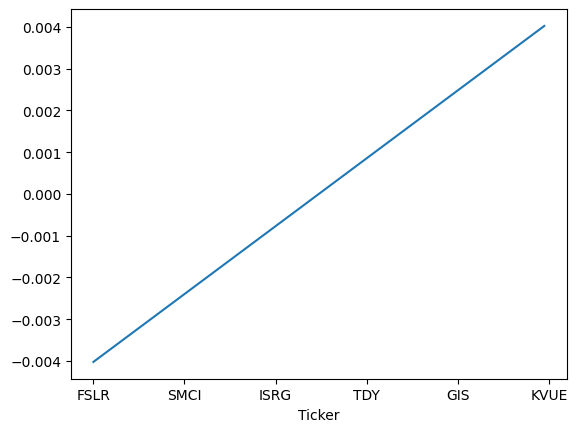

In [6]:
# example portfolio
port.loc['20210330'].sort_values().plot()

<Axes: xlabel='Date'>

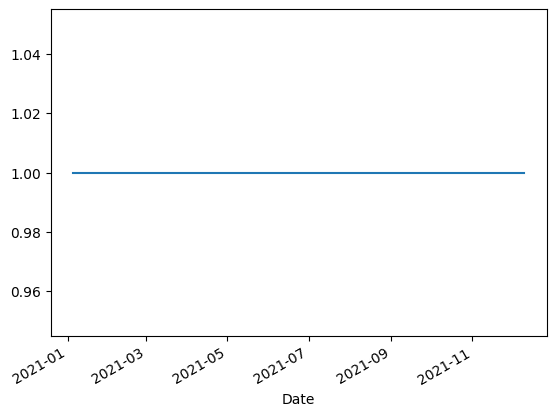

In [7]:
# Fully invested: abs value of port weights should sum to 1
port.abs().sum(1).plot()

<Axes: xlabel='Date'>

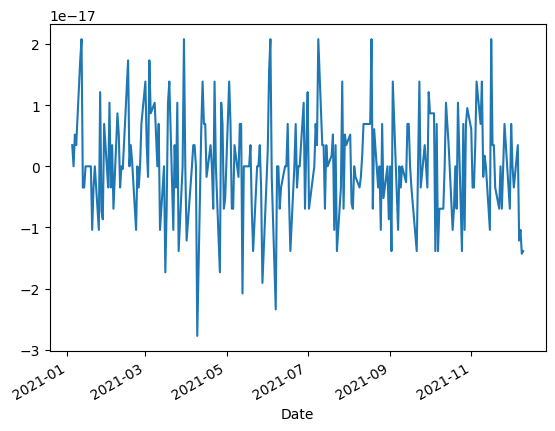

In [8]:
# Dollar neutrality: Port weights should sum to 0
port.sum(1).plot()

In [9]:
# compute strategy returns: implicitly assuming "market orders"
strat_ret = (port.shift()*ret).sum(1)

In [10]:
get_stats(strat_ret)

SR     1.470817
ret    0.097637
vol    0.066383
dtype: float64

<Axes: xlabel='Date'>

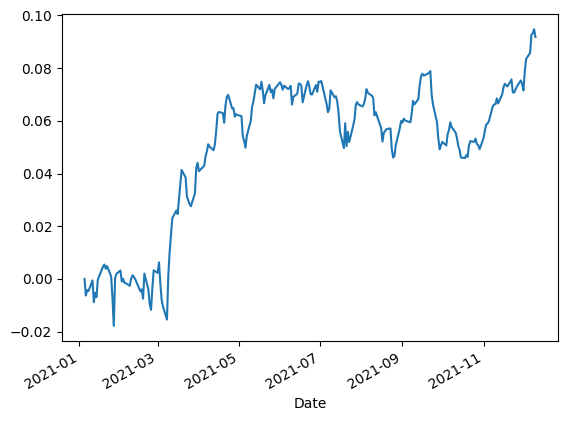

In [11]:
strat_ret.cumsum().plot()

### Create a simple XS 1 day reversal strategy using decile portfolios

In [12]:
negate = ret*-.1
pct = negate.rank(axis=1,pct=True)

long = (pct > 0.9)*1
long = long.divide(long.abs().sum(1),0)*0.5

short = (pct < 0.1)*-1.0
short = short.divide(short.abs().sum(1),0)*0.5

port = short.add(long,fill_value = 0)

<Axes: xlabel='Ticker'>

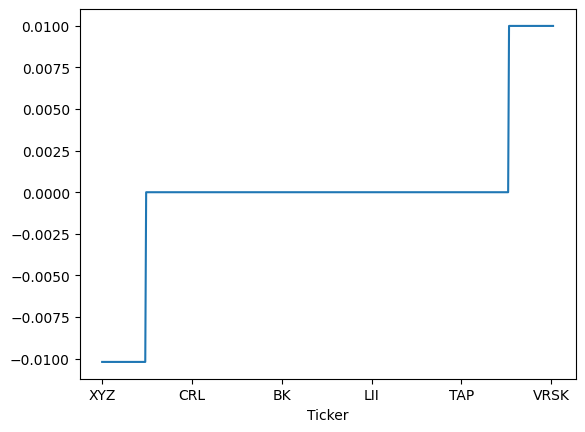

In [13]:
# example portfolio
port.loc['20210330'].sort_values().plot()

<Axes: xlabel='Date'>

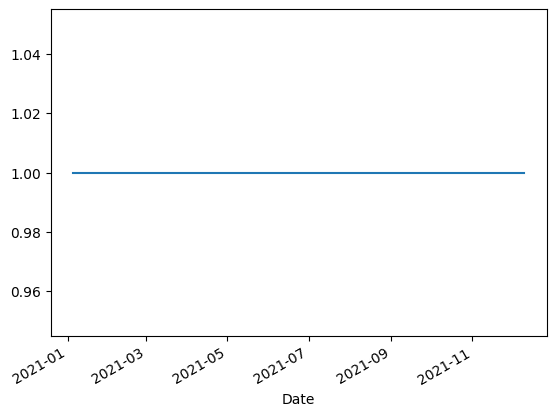

In [14]:
# Fully invested: abs value of port weights should sum to 1
(port.abs()).sum(1).plot()

<Axes: xlabel='Date'>

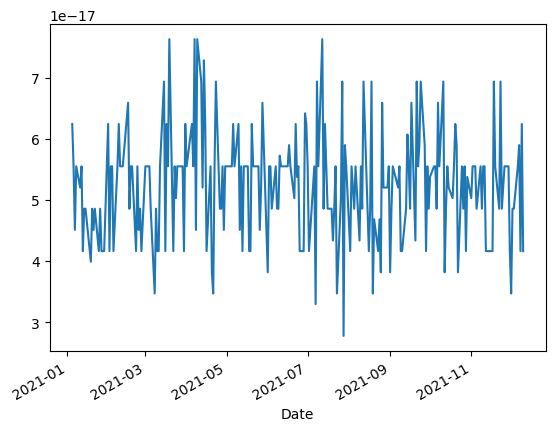

In [15]:
# Dollar neutrality: Port weights should sum to 0
port.sum(1).plot()

In [16]:
# compute strategy returns: implicitly assuming "market orders"
strat_ret = (port.shift()*ret).sum(1)

In [17]:
get_stats(strat_ret)

SR     1.078070
ret    0.116412
vol    0.107982
dtype: float64

<AxesSubplot:xlabel='Date'>

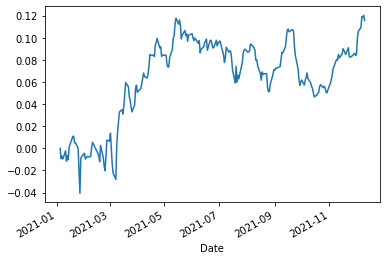

In [ ]:
strat_ret.cumsum().plot()